In [51]:
import sys
!"{sys.executable}" -m pip install imageio


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import squarify
import gc
import geodatasets

import scipy
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
import scipy.spatial.distance
from scipy.spatial.distance import pdist

import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

from pathlib import Path


In [13]:
# C:\Users\braup\OneDrive\Escritorio\TAREAS\ULTIMO_CUATRI\Pedrozo\Advanced-Data-Visualization-Storytelling-Practice\data_files\csv\youtube_videos_final.csv
current_dir = Path().resolve()
youtube_videos_path = current_dir.parent / "data_files" / "csv" / "youtube_videos_final.csv"

In [14]:
df = pd.read_csv(youtube_videos_path)

# Dviding data to work analytics and create pipeline so it can be applied to full dataset later
df_subset = df.sample(n=(len(df)//10), random_state=42)
df = None
gc.collect()

1249

In [15]:
print(df_subset.head())
print(df_subset.info())
print(df_subset.describe())
print(df_subset.columns)
print(df_subset.isnull().sum())
print(df_subset.dtypes)
print(df_subset.shape)

           video_id country trending_date  \
351141  GcKkiRl9_qE      US      18.04.02   
172566  qoaad0TKV4I      IN      18.14.01   
197044  b8V_5KGyLr0      IN      18.05.06   
286861  qpgjMrtR7d8      MX      18.06.05   
53793   RXBZ4LVtKhE      DE      18.19.01   

                                                    title     channel_title  \
351141     Rooftop POV Escape from Hong Kong security! 🇭🇰       StorrorBlog   
172566  மாபெரும் வெற்றி பெற்ற 5 முட்டாள் தனமான முயற்சி...    Kollywood Talk   
197044  நாயகி புரொமோ இன்று 04/06/18 | Naayagi Promo fo...  Deivamagal Today   
286861   La lecciÃ³n de las encuestas: Â¡A ponerse pilas!  El Hijo del Rayo   
53793   60 минут. ГРЯЗНЫЕ ПРИЕМЫ США: какие силы и сре...         Россия 24   

        category_id    category_name              publish_time  \
351141           24    Entertainment  2018-01-29T17:00:01.000Z   
172566           22   People & Blogs  2018-01-11T07:19:55.000Z   
197044           22   People & Blogs  2018-06-04T15:32:4

In [16]:
# Based on the previous information we can start cleaning and preprocessing the data
df_subset["publish_time"] = pd.to_datetime(df_subset["publish_time"], errors="coerce")
df_subset["trending_date"] = pd.to_datetime(df_subset["trending_date"], format="%y.%d.%m", errors="coerce")

# Extracting temporal components
df_subset["trending_year"  ] = df_subset["trending_date"].dt.year
df_subset["trending_month" ] = df_subset["trending_date"].dt.month
df_subset["trending_day"   ] = df_subset["trending_date"].dt.day
df_subset["trending_week"] = df_subset["trending_date"].dt.isocalendar().week

# Ensure spatial dimension consistency
country_counts = df_subset['country'].value_counts()
print("Data loaded and time-space variables extracted.")
display(df_subset.head(), country_counts)

Data loaded and time-space variables extracted.


,video_id,country,trending_date,title,channel_title,category_id,category_name,publish_time,tags,views,...,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,trending_year,trending_month,trending_day,trending_week
351141,GcKkiRl9_qE,US,2018-02-04,Rooftop POV Escape from Hong Kong security! 🇭🇰,StorrorBlog,24,Entertainment,2018-01-29 17:00:01+00:00,"pov|""chase""|""police""|""vs""|""cliff""|""diving""|""pa...",827814,...,4565,https://i.ytimg.com/vi/GcKkiRl9_qE/default.jpg,False,False,False,Escaping crazy dude on the rooftops of megacit...,2018,2,4,5
172566,qoaad0TKV4I,IN,2018-01-14,மாபெரும் வெற்றி பெற்ற 5 முட்டாள் தனமான முயற்சி...,Kollywood Talk,22,People & Blogs,2018-01-11 07:19:55+00:00,"5 insane ideas worked|""5 crazy ideas worked ve...",1009343,...,180,https://i.ytimg.com/vi/qoaad0TKV4I/default.jpg,False,False,False,மாபெரும் வெற்றி பெற்ற 5 முட்டாள் தனமான முயற்சி...,2018,1,14,2
197044,b8V_5KGyLr0,IN,2018-06-05,நாயகி புரொமோ இன்று 04/06/18 | Naayagi Promo fo...,Deivamagal Today,22,People & Blogs,2018-06-04 15:32:41+00:00,"naayagi|""vikatan new serial""|""naayagi new seri...",51497,...,12,https://i.ytimg.com/vi/b8V_5KGyLr0/default.jpg,False,False,False,"Naayagi Episode for Episode 91, 04.06.18 naaya...",2018,6,5,23
286861,qpgjMrtR7d8,MX,2018-05-06,La lecciÃ³n de las encuestas: Â¡A ponerse pilas!,El Hijo del Rayo,25,News & Politics,2018-05-06 03:38:59+00:00,"AMLO|""MORENA""|""PRI""|""Meade""|""Anaya""|""PAN""|""INE...",2900,...,72,https://i.ytimg.com/vi/qpgjMrtR7d8/default.jpg,False,False,False,La lecciÃ³n de las encuestas: Â¡A ponerse pilas!,2018,5,6,18
53793,RXBZ4LVtKhE,DE,2018-01-19,60 минут. ГРЯЗНЫЕ ПРИЕМЫ США: какие силы и сре...,Россия 24,24,Entertainment,2018-01-18 17:06:19+00:00,"последние новости|""Россия 24""|""онлайн""|""новост...",163753,...,1037,https://i.ytimg.com/vi/RXBZ4LVtKhE/default.jpg,False,False,False,Подпишитесь на канал 60 минут: https://www.you...,2018,1,19,3


country
DE    4143
US    4142
CA    4119
RU    4089
FR    3995
MX    3914
GB    3862
IN    3776
KR    3433
JP    2121
Name: count, dtype: int64

Available columns in world dataset:
['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_

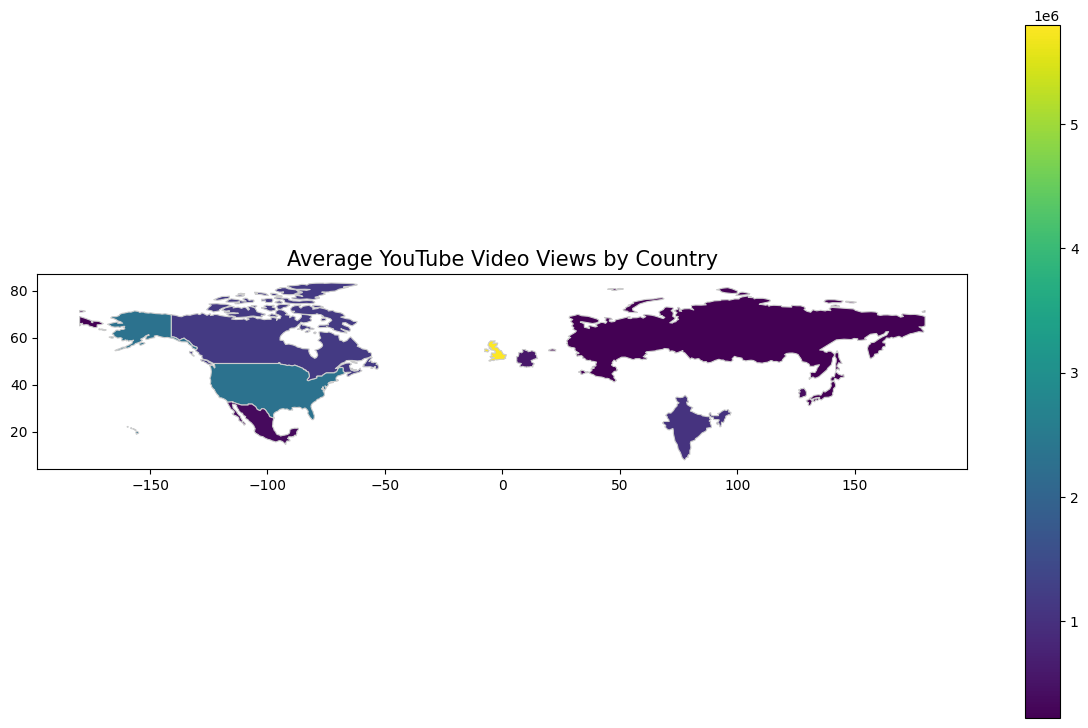

In [23]:
geo_summary = df_subset.groupby('country').agg({
    'views':'mean', 'likes':'mean', 'dislikes':'mean', 'comment_count':'mean'
}).reset_index()

# Loading world map for display
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# First, let's check what columns are available
print("Available columns in world dataset:")
print(world.columns.tolist())

# The column is likely 'ISO_A2' (uppercase) or 'iso_a2_eh'
# Try this merge instead:
geo_summary = world.merge(geo_summary, how='left', left_on='ISO_A2', right_on='country')

# Plotting geographic distribution of average views
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
geo_summary.plot(column='views', cmap="viridis", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
ax.set_title("Average YouTube Video Views by Country", fontdict={'fontsize': 15})
plt.show()

### Temoporal analysis

C:\Users\braup\AppData\Local\Temp\ipykernel_13412\1366730956.py:25: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


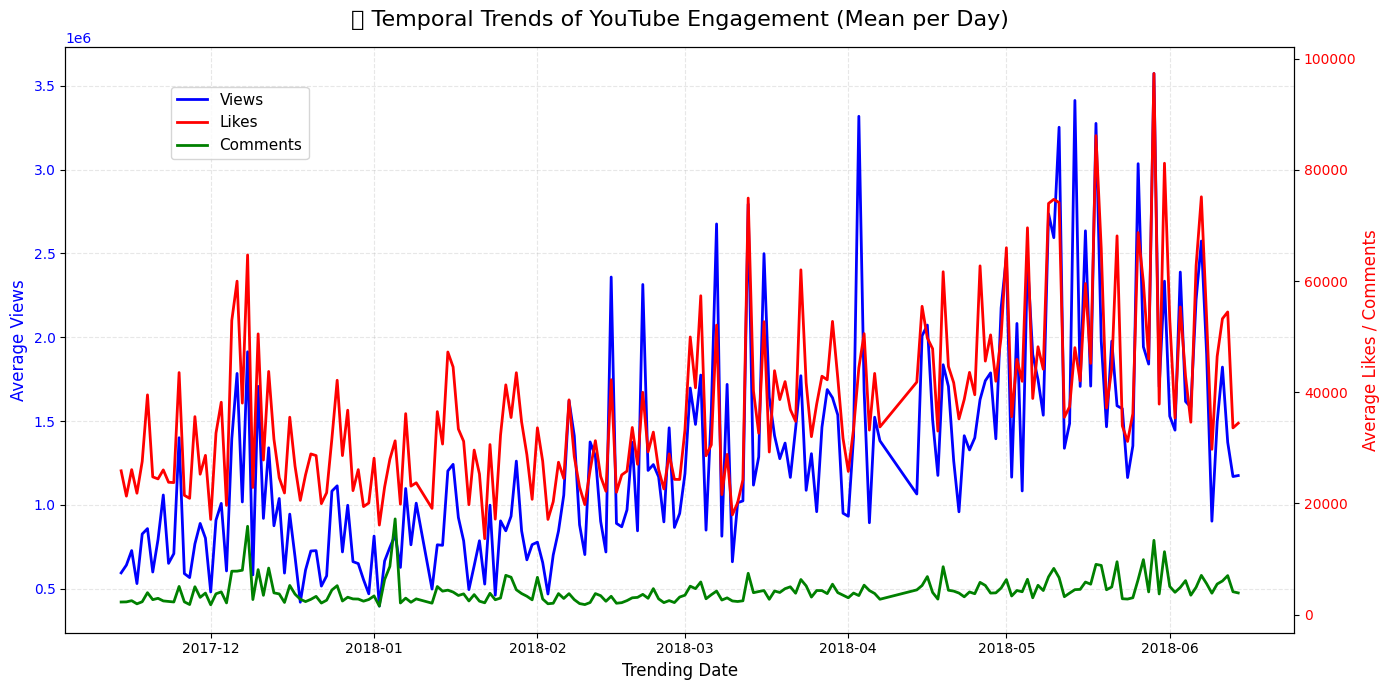

In [ ]:
# Alternative: Dual-axis plot for better visibility
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot views on primary axis
ax1.plot(temporal_trends['trending_date'], temporal_trends['views'],
         color='blue', linewidth=2, label='Views')
ax1.set_xlabel('Trending Date', fontsize=12)
ax1.set_ylabel('Average Views', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(alpha=0.3, linestyle='--')

# Create secondary axis for likes and comments
ax2 = ax1.twinx()
ax2.plot(temporal_trends['trending_date'], temporal_trends['likes'],
         color='red', linewidth=2, label='Likes')
ax2.plot(temporal_trends['trending_date'], temporal_trends['comment_count'],
         color='green', linewidth=2, label='Comments')
ax2.set_ylabel('Average Likes / Comments', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legends
plt.title('⏰ Temporal Trends of YouTube Engagement (Mean per Day)', fontsize=16, pad=15)
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\braup\AppData\Local\Temp\ipykernel_13412\1558374678.py:21: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


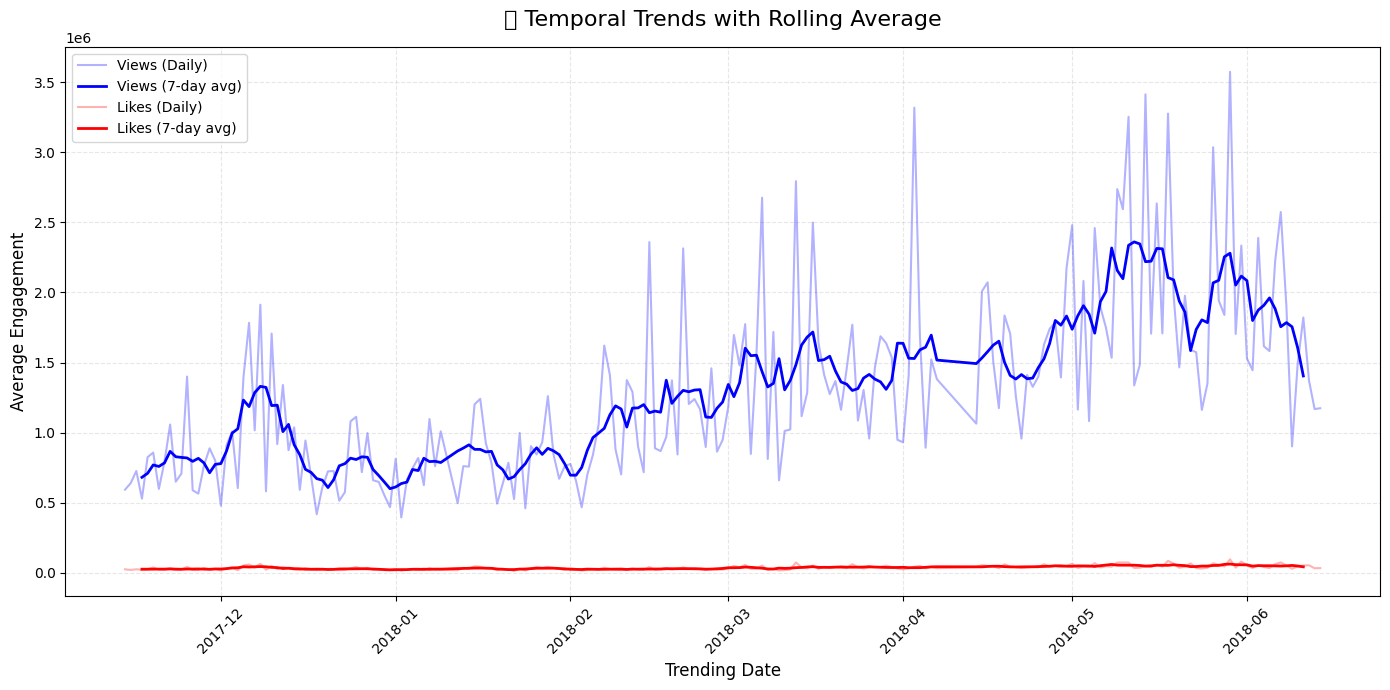

In [ ]:
# Calculate 7-day rolling average for smoother trends
temporal_trends['views_rolling'] = temporal_trends['views'].rolling(window=7, center=True).mean()
temporal_trends['likes_rolling'] = temporal_trends['likes'].rolling(window=7, center=True).mean()

plt.figure(figsize=(14, 7))
plt.plot(temporal_trends['trending_date'], temporal_trends['views'],
         alpha=0.3, color='blue', label='Views (Daily)')
plt.plot(temporal_trends['trending_date'], temporal_trends['views_rolling'],
         linewidth=2, color='blue', label='Views (7-day avg)')
plt.plot(temporal_trends['trending_date'], temporal_trends['likes'],
         alpha=0.3, color='red', label='Likes (Daily)')
plt.plot(temporal_trends['trending_date'], temporal_trends['likes_rolling'],
         linewidth=2, color='red', label='Likes (7-day avg)')

plt.title('⏰ Temporal Trends with Rolling Average', fontsize=16, pad=15)
plt.xlabel('Trending Date', fontsize=12)
plt.ylabel('Average Engagement', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

C:\Users\braup\AppData\Local\Temp\ipykernel_13412\3280948347.py:23: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


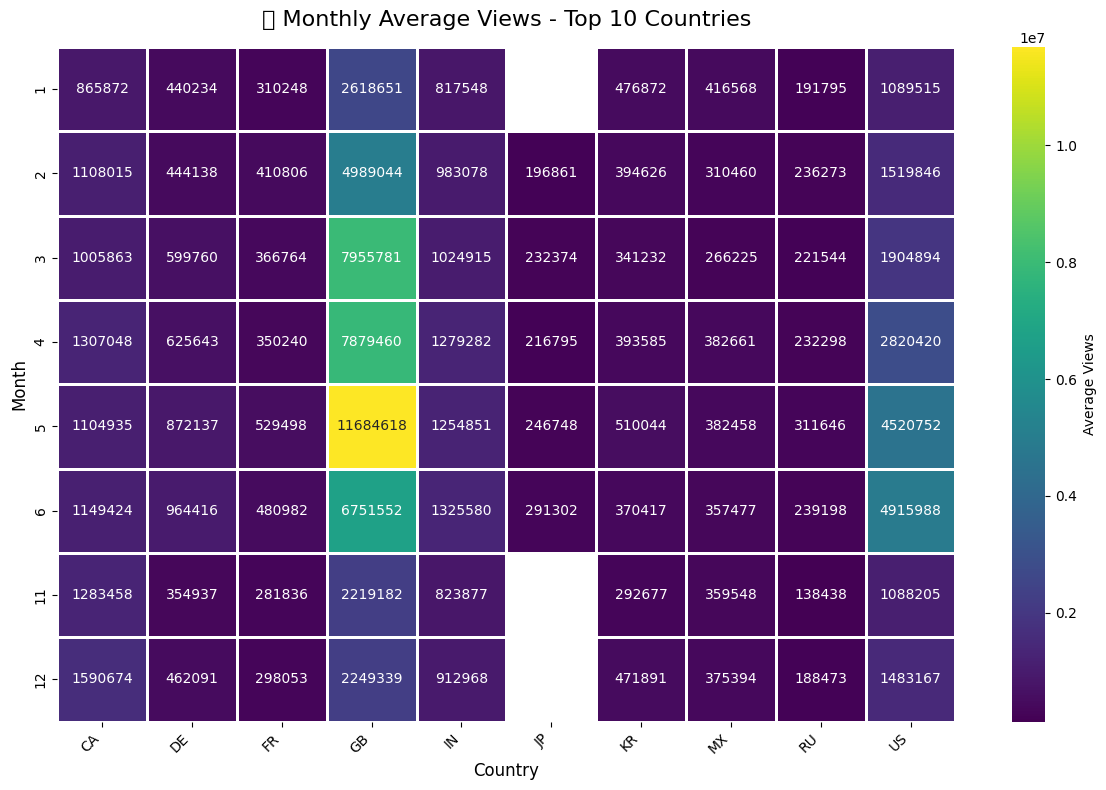

In [ ]:
pivot_views = country_time.pivot(index='trending_month', columns='country', values='views')

# Sort months chronologically (if month is numeric or datetime)
pivot_views = pivot_views.sort_index()

# Normalize values by country to see relative patterns
from scipy import stats

# Focus on top N countries by total views for clearer visualization
top_countries = df_subset.groupby('country')['views'].sum().nlargest(10).index
country_time_top = country_time[country_time['country'].isin(top_countries)]

pivot_views_top = country_time_top.pivot(index='trending_month', columns='country', values='views')
pivot_views_top = pivot_views_top.sort_index()

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_views_top, cmap='viridis', annot=True, fmt='.0f',
            linewidths=1, cbar_kws={'label': 'Average Views'})
plt.title('🌐 Monthly Average Views - Top 10 Countries', fontsize=16, pad=15)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\braup\AppData\Local\Temp\ipykernel_13412\4252534320.py:19: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


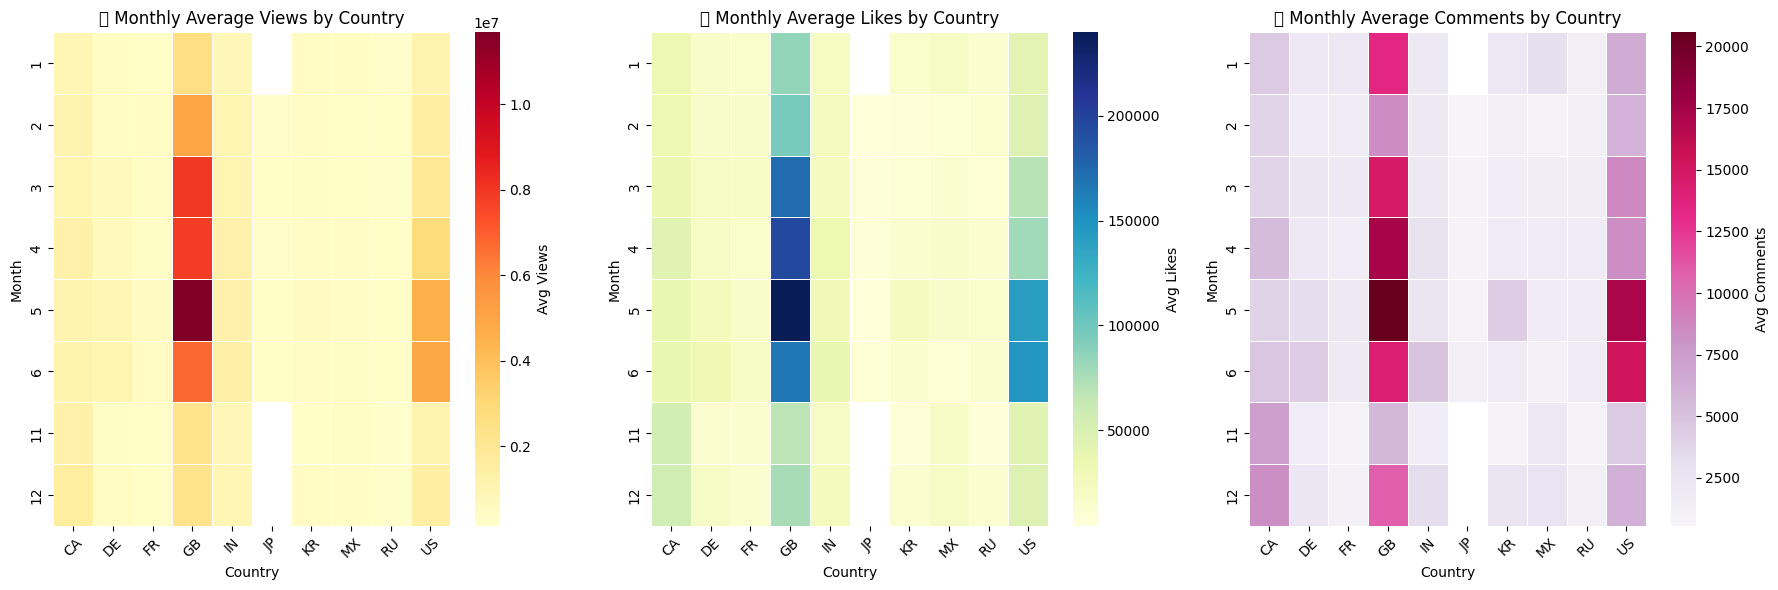

In [ ]:
# Create subplots for views, likes, and comments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['views', 'likes', 'comment_count']
titles = ['Views', 'Likes', 'Comments']
cmaps = ['YlOrRd', 'YlGnBu', 'PuRd']

for ax, metric, title, cmap in zip(axes, metrics, titles, cmaps):
    pivot_data = country_time.pivot(index='trending_month', columns='country', values=metric)
    pivot_data = pivot_data.sort_index()

    sns.heatmap(pivot_data, cmap=cmap, annot=False, ax=ax,
                linewidths=0.5, cbar_kws={'label': f'Avg {title}'})
    ax.set_title(f'🌐 Monthly Average {title} by Country', fontsize=12)
    ax.set_xlabel('Country', fontsize=10)
    ax.set_ylabel('Month', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Clearly there is a correlation between views, likes and comments over time and by country.

In [43]:
# Find the peak month for each country
peak_months = pivot_views.idxmax(axis=0)
print("\n📊 Peak Engagement Month by Country:")
print(peak_months.to_frame(name='Peak Month').sort_values('Peak Month'))

# Statistical summary
print("\n📈 Overall Temporal Statistics:")
display(country_time.groupby('trending_month')['views'].agg(['mean', 'std', 'min', 'max']))


📊 Peak Engagement Month by Country:
         Peak Month
country            
MX                1
FR                5
GB                5
KR                5
RU                5
DE                6
IN                6
JP                6
US                6
CA               12

📈 Overall Temporal Statistics:


,mean,std,min,max
trending_month,,,,
1,8.030337e+05,7.404819e+05,191795.056838,2.618651e+06
2,1.059315e+06,1.448596e+06,196860.797927,4.989044e+06
3,1.391935e+06,2.366316e+06,221544.001621,7.955781e+06
4,1.548743e+06,2.364458e+06,216794.638393,7.879460e+06
5,2.141769e+06,3.582313e+06,246747.625000,1.168462e+07
6,1.684634e+06,2.261203e+06,239198.280156,6.751552e+06
11,7.602398e+05,6.775718e+05,138437.675214,2.219182e+06
12,8.924500e+05,7.207938e+05,188473.146730,2.249339e+06


C:\Users\braup\AppData\Local\Temp\ipykernel_13412\290694875.py:29: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


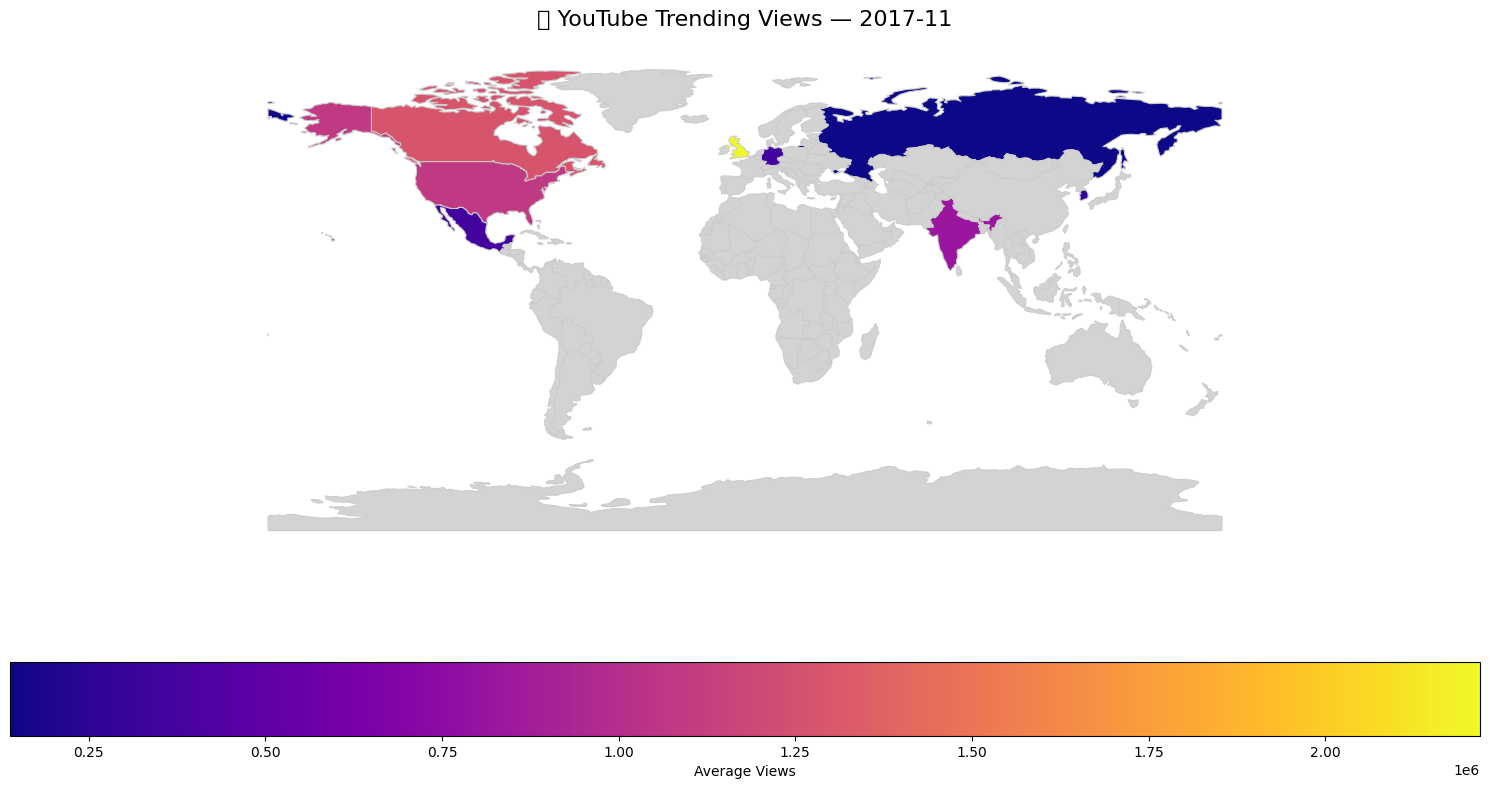

In [ ]:
# 🗺️ Advanced Map: Consistent Temporal Intervals for Map Animation Preparation

# 1. Normalize time intervals (e.g., monthly mean per country)
geo_time = df_subset.groupby(['country', 'trending_year', 'trending_month']).agg({
    'views': 'mean'
}).reset_index()

# 2. Create year-month column for temporal consistency
geo_time['year_month'] = geo_time['trending_year'].astype(str) + '-' + geo_time['trending_month'].astype(str).str.zfill(2)

# Sort by time for proper animation sequence
geo_time = geo_time.sort_values('year_month')

# 3. Example static map for one month (with error handling)
selected_period = geo_time[geo_time['year_month'] == geo_time['year_month'].unique()[0]]

# Use the correct column name from world dataset (ISO_A2 instead of iso_a2)
geo_temp = world.merge(selected_period, left_on='ISO_A2', right_on='country', how='left')

# Create figure with better styling
fig, ax = plt.subplots(figsize=(15, 8))
geo_temp.plot(column='views', cmap='plasma', linewidth=0.8, ax=ax,
              edgecolor='0.8', legend=True, missing_kwds={'color': 'lightgrey'},
              legend_kwds={'label': 'Average Views', 'orientation': 'horizontal'})

ax.set_title(f'🗺️ YouTube Trending Views — {selected_period["year_month"].iloc[0]}',
             fontsize=16, pad=15)
ax.axis('off')  # Remove axis for cleaner map
plt.tight_layout()
plt.show()

# 🧠 Big Idea:
# - Each month can be visualized in sequence for map animation.
# - Enables consistent geographic comparison through time.

c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:480: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:950: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:480: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:950: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
c:\Users\braup\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\plotting.py:480: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
 

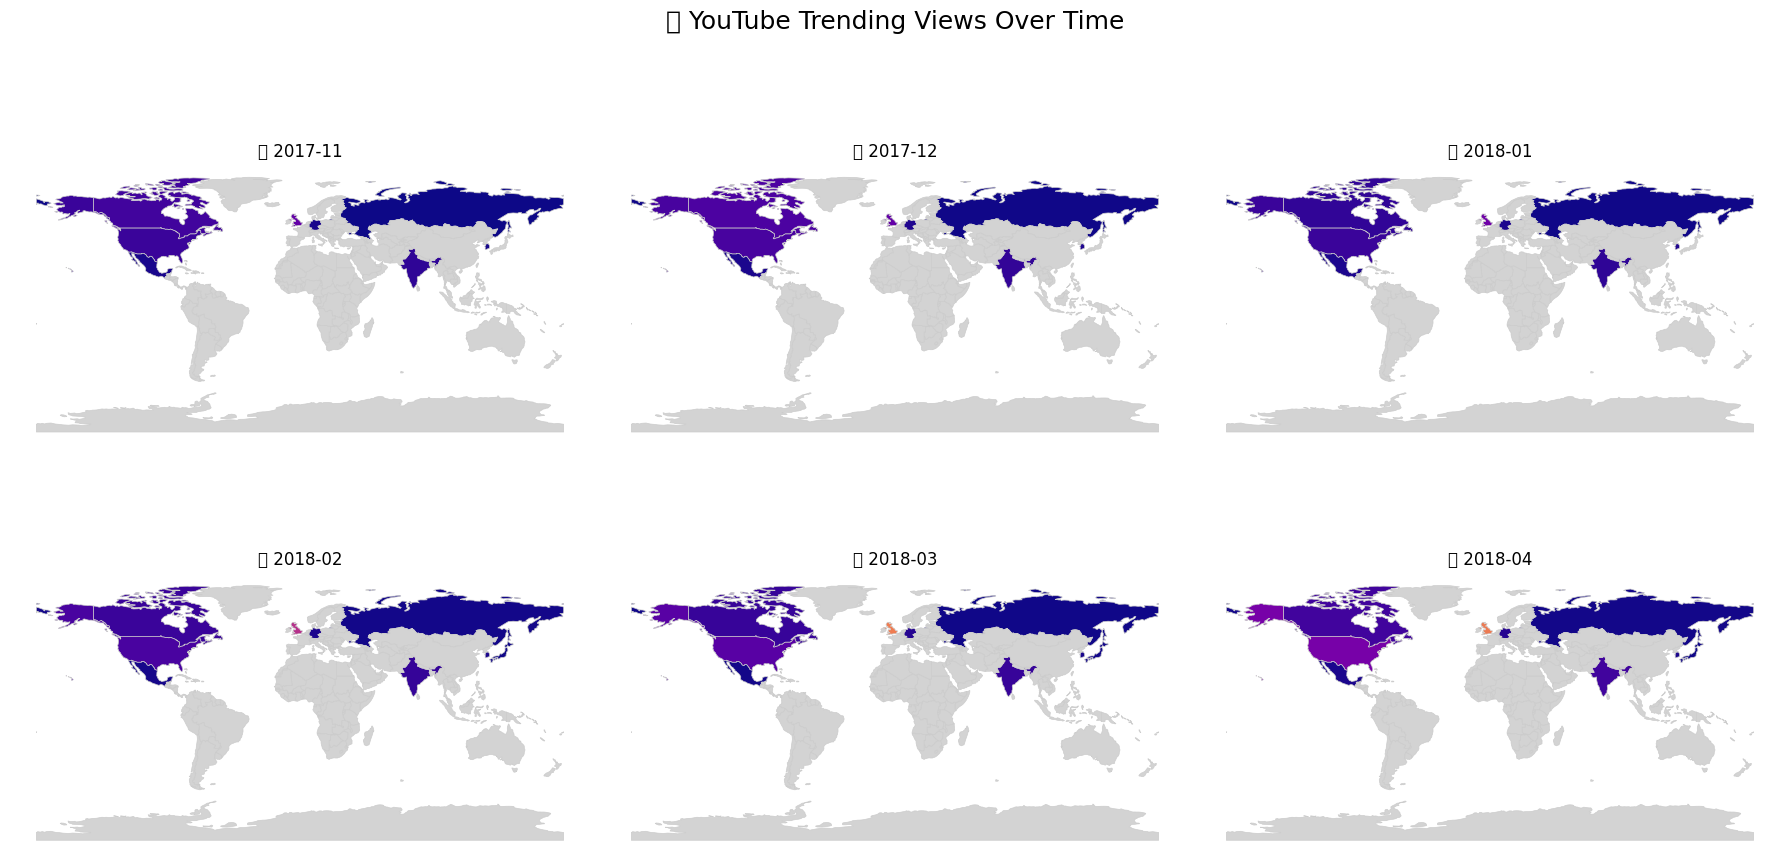

In [ ]:
# Generate maps for all time periods
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Get consistent color scale across all periods
vmin = geo_time['views'].min()
vmax = geo_time['views'].max()

# Create maps for first few periods (or all if you want full animation)
unique_periods = geo_time['year_month'].unique()[:6]  # First 6 months as example

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, period in enumerate(unique_periods):
    selected_period = geo_time[geo_time['year_month'] == period]
    geo_temp = world.merge(selected_period, left_on='ISO_A2', right_on='country', how='left')

    geo_temp.plot(column='views', cmap='plasma', linewidth=0.5, ax=axes[idx],
                  edgecolor='0.8', legend=False, vmin=vmin, vmax=vmax,
                  missing_kwds={'color': 'lightgrey'})

    axes[idx].set_title(f'📅 {period}', fontsize=12)
    axes[idx].axis('off')

plt.suptitle('🗺️ YouTube Trending Views Over Time', fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
garbage_collection = gc.collect()
print(f"Garbage collection completed. Objects collected: {garbage_collection}")

In [ ]:
%whos

In [ ]:
# 🧩 Unified Spatiotemporal Analysis Pipeline
def spatiotemporal_pipeline(df):
    """
    Comprehensive spatiotemporal analysis of YouTube trending data.
    Generates geographic maps, time series, and heatmaps.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import geopandas as gpd
    from datetime import datetime

    print("🔄 Starting spatiotemporal analysis pipeline...")

    # ---- Data Cleaning & Enrichment ----
    print("📊 Step 1: Cleaning and enriching data...")
    df = df.copy()  # Avoid modifying original dataframe

    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
    df['year'] = df['trending_date'].dt.year
    df['month'] = df['trending_date'].dt.month
    df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

    # Remove rows with missing critical data
    df = df.dropna(subset=['trending_date', 'country', 'views'])

    # ---- Aggregations ----
    print("📈 Step 2: Computing aggregations...")

    # Geographic aggregation
    geo_summary = df.groupby('country').agg({
        'views': 'mean',
        'likes': 'mean',
        'comment_count': 'mean'
    }).reset_index()

    # Temporal aggregation
    temporal_trends = df.groupby('trending_date').agg({
        'views': 'mean',
        'likes': 'mean'
    }).reset_index().sort_values('trending_date')

    # Combined spatiotemporal
    geo_time = df.groupby(['country', 'year_month']).agg({
        'views': 'mean'
    }).reset_index()

    # ---- Load World Map ----
    print("🗺️ Step 3: Loading geographic data...")
    try:
        # Try using Natural Earth data directly (recommended)
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        world = gpd.read_file(url)
        iso_column = 'ISO_A2'  # Correct column name
    except Exception as e:
        print(f"⚠️ Could not load world map: {e}")
        print("✅ Skipping map visualization...")
        world = None
        iso_column = None

    # ---- Visualization 1: Geographic Map ----
    if world is not None:
        print("🌍 Step 4: Generating geographic map...")
        geo_world = world.merge(geo_summary, left_on=iso_column, right_on='country', how='left')

        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        geo_world.plot(column='views', cmap='viridis', linewidth=0.8, ax=ax,
                       edgecolor='0.8', legend=True,
                       missing_kwds={'color': 'lightgrey'},
                       legend_kwds={'label': 'Average Views', 'shrink': 0.5})
        ax.set_title('🌍 Average YouTube Views per Country', fontsize=16, pad=15)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    # ---- Visualization 2: Time Series ----
    print("⏰ Step 5: Generating time series plot...")
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.lineplot(data=temporal_trends, x='trending_date', y='views',
                 label='Views', linewidth=2, color='blue', ax=ax)
    sns.lineplot(data=temporal_trends, x='trending_date', y='likes',
                 label='Likes', linewidth=2, color='red', ax=ax)

    ax.set_title('⏰ Global YouTube Engagement Over Time', fontsize=16, pad=15)
    ax.set_xlabel('Trending Date', fontsize=12)
    ax.set_ylabel('Average Engagement', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---- Visualization 3: Spatiotemporal Heatmap ----
    print("🌐 Step 6: Generating spatiotemporal heatmap...")

    # Filter to top countries for better readability
    top_countries = geo_summary.nlargest(15, 'views')['country'].tolist()
    geo_time_filtered = geo_time[geo_time['country'].isin(top_countries)]

    pivot_views = geo_time_filtered.pivot(index='year_month', columns='country', values='views')
    pivot_views = pivot_views.sort_index()

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(pivot_views, cmap='YlOrRd', annot=False, fmt='.0f',
                linewidths=0.5, cbar_kws={'label': 'Average Views'}, ax=ax)
    ax.set_title('🌐 Spatiotemporal Heatmap — Views by Country & Time (Top 15 Countries)',
                 fontsize=16, pad=15)
    ax.set_xlabel('Country', fontsize=12)
    ax.set_ylabel('Year-Month', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ---- Summary Statistics ----
    print("\n📊 Summary Statistics:")
    print(f"  • Total countries analyzed: {df['country'].nunique()}")
    print(f"  • Time range: {df['trending_date'].min()} to {df['trending_date'].max()}")
    print(f"  • Total records: {len(df):,}")
    print(f"  • Average views per video: {df['views'].mean():,.0f}")
    print(f"  • Average likes per video: {df['likes'].mean():,.0f}")

    print("\n🔥 Top 5 Countries by Average Views:")
    print(geo_summary.nlargest(5, 'views')[['country', 'views']])

    print("\n✅ Unified spatiotemporal analysis complete. Ready for scaling.")

    return {
        'geo_summary': geo_summary,
        'temporal_trends': temporal_trends,
        'geo_time': geo_time,
        'pivot_views': pivot_views
    }

# Example usage:
results = spatiotemporal_pipeline(df)
